In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from sklearn import linear_model
from scipy.spatial.distance import cosine
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

sb.set_context("poster")
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def get_stock(stock_ticker):
    stock = yf.Ticker(stock_ticker)
    #periods = “1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
    stock_dic = {}
    stock_dic['ticker'] = stock_ticker
    stock_dic['1d'] = stock.history(period='1d', interval='1m', actions=False)
    stock_dic['5d'] = stock.history(period='5d', interval='1d', actions=False)
    stock_dic['1mo'] = stock.history(period='1mo', interval='1d', actions=False)
    stock_dic['6mo'] = stock.history(period='6mo', interval='1d', actions=False)
    
    return stock_dic

In [3]:
def get_fits(stock_dic):
    for key in stock_dic.keys():
        if key != 'ticker':
            period = key
            df_copy = stock_dic[key].copy()
            if period == '1d':
                df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).seconds
            else:
                df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).days
            x = df_copy.loc[:, 'period_from_start'].T
            y = df_copy.loc[:, 'Close']
            polyfit_close = np.polyfit(x, y, 1)
            function = np.poly1d(polyfit_close) 
            df_copy['linear_fit'] = function(df_copy.loc[:, 'period_from_start'])

            #https://newbedev.com/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
            if period == '6mo':
                scaler = MinMaxScaler(feature_range=(-1, 1))
                df_copy.loc[:, 'no_trend'] = scaler.fit_transform(np.expand_dims(df_copy['Close'].values - df_copy['linear_fit'].values, axis=1))
                #df_copy.loc[:, 'no_trend'] = df_copy.loc[:, 'Close'] - df_copy.loc[:, 'linear_fit']
                res = fit_sine(df_copy.loc[:, 'period_from_start'], df_copy.loc[:, 'no_trend'])
                df_copy.loc[:, 'fit_sine'] = res['fit_func'](df_copy.loc[:, 'period_from_start'])
            
            #is it ok to be changing and returning stock_dic or should I make a new copy and return that?
            stock_dic[key] = df_copy

    return stock_dic

In [4]:
def get_fits2(df, period):
    df_copy = df.copy()
    if period == '1d':
        df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).seconds
    else:
        df_copy['period_from_start'] = (df_copy.index - df_copy.index[0]).days
    x = df_copy.loc[:, 'period_from_start'].T
    y = df_copy.loc[:, 'Close']
    polyfit_close = np.polyfit(x, y, 1)
    function = np.poly1d(polyfit_close) 
    df_copy['linear_fit'] = function(df_copy.loc[:, 'period_from_start'])
    
    #https://newbedev.com/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    if period == '6mo':
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df_copy.loc[:, 'no_trend'] = scaler.fit_transform(np.expand_dims(df_copy['Close'].values - df_copy['linear_fit'].values, axis=1))
        #df_copy.loc[:, 'no_trend'] = df_copy.loc[:, 'Close'] - df_copy.loc[:, 'linear_fit']
        res = fit_sine(df_copy.loc[:, 'period_from_start'], df_copy.loc[:, 'no_trend'])
        df_copy.loc[:, 'fit_sine'] = res['fit_func'](df_copy.loc[:, 'period_from_start'])

    return df_copy

In [5]:
def get_values(dic):
    #get values for each period and put into df
    to_df = {}
    
    for i, key in enumerate(dic.keys()):
        if i > 0:
            df = dic[key]
            values_dic = {}
            values_dic['min_val'] = round(df.loc[:, 'Close'].min(), 2)
            values_dic['min_idx'] = df.loc[:, 'Close'].idxmin()
            values_dic['max_val'] = round(df.loc[:, 'Close'].max(), 2)
            values_dic['max_idx'] = df.loc[:, 'Close'].idxmax()
            values_dic['mean_val'] = round(df.loc[:, 'Close'].mean(), 2)
            values_dic['last_val'] = round(df.loc[:, 'Close'].iloc[-1], 2)
            values_dic['last_idx'] = df.index[-1]
            values_dic['last_linear'] = round(df.loc[:, 'linear_fit'].iloc[-1], 2)

            #index_diff = (df.index[1] - df.index[0]).total_seconds()
            slope_diff = df.loc[:, 'linear_fit'].iloc[1] - df.loc[:, 'linear_fit'].iloc[0]
            #values_dic['linear_diff_by_sec'] = slope_diff / index_diff

            if slope_diff > 0:
                sign = '+'
            elif slope_diff < 0:
                sign = '-'
            values_dic['linear_sign'] = sign

            df_copy = df.copy()
            df_copy['mean_for_cosine'] = values_dic['mean_val']
            values_dic['cosine_similarity'] = round(1 - cosine(df['linear_fit'], df_copy['mean_for_cosine']), 4)
            
            if key == '6mo':
                values_dic['sine_max'] = df.loc[:, 'fit_sine'].max()
                values_dic['sine_min'] = df.loc[:, 'fit_sine'].min()
                values_dic['sine_mean'] = df.loc[:, 'fit_sine'].mean()
                values_dic['sine_last'] = df.loc[:, 'fit_sine'].iloc[-1]
            
            to_df[key] = values_dic
    
    val_df = pd.DataFrame.from_dict(to_df, orient='index')
    
    return val_df

In [6]:
def percent_diff(val_1, val_2, percent = 0.05):
    return (val_1 - val_2) * percent

In [7]:
def graph(stock_dic, val_df):
    plt.rcParams.update({'font.size': 22})
    if 'ticker' in stock_dic.keys():
        fig, ax = plt.subplots(len(stock_dic.keys()) - 1, figsize=(30, 30))
    
    for j, key in enumerate(stock_dic.keys()):
        if j > 0:
            i = j - 1
            ax[i].set_title(f'{stock_dic["ticker"]} {key}')
            ax[i].plot(stock_dic[key].loc[:, 'Close'], color='b', label='Close')
            ax[i].plot(stock_dic[key].loc[:, 'linear_fit'], color='r', label='Linear Fit')
            ax[i].axhline(val_df.loc[key, 'mean_val'], color='orange', label='Mean')
            
            if key == '6mo':
                ax2 = ax[i].twinx()
                ax2.plot(stock_dic[key].loc[:, 'fit_sine'], color='green', label='Sine Fit')
                #ax2.plot(stock_dic[key].loc[:, 'no_trend'], color='purple', label='Detrended')
                ax2.tick_params(axis='y', labelrotation=45, labelcolor='green')
                ax2.legend(loc='upper center')
                ax2.set_ylabel('Adjusted Price')

            ax[i].annotate(val_df.loc[key, 'max_val'], (val_df.loc[key, 'max_idx'], val_df.loc[key, 'max_val']))
            ax[i].annotate(val_df.loc[key, 'min_val'], (val_df.loc[key, 'min_idx'], val_df.loc[key, 'min_val']))
            ax[i].annotate(val_df.loc[key, 'last_val'], (val_df.loc[key, 'last_idx'], val_df.loc[key, 'last_val']))
            ax[i].annotate(val_df.loc[key, 'last_linear'], (val_df.loc[key, 'last_idx'], val_df.loc[key, 'last_linear']))
            ax[i].annotate(val_df.loc[key, 'mean_val'], (val_df.loc[key, 'last_idx'], val_df.loc[key, 'mean_val']))

            ax[i].legend()
            ax[i].set_xlabel('Date')
            ax[i].set_ylabel('Price ($)')
            ax[i].tick_params(labelrotation=45)
    
    plt.tight_layout()
    plt.show()

In [8]:
def analysis(stock_dic, val_df):
    #info about max and min
    print(f"Current price: {val_df.loc['1d', 'last_val']}")
    for key in stock_dic.keys():
        if key in ('5d', '1mo', '6mo'):
            print(f"{key} Max: {val_df.loc[key, 'max_val']} Min: {val_df.loc[key, 'min_val']} Distance from mean: {round((val_df.loc[key, 'last_val'] - val_df.loc[key, 'mean_val']), 2)} Cosine similarity: {val_df.loc[key, 'linear_sign']}{val_df.loc[key, 'cosine_similarity']}")
            
            if round(val_df.loc[key, 'last_val']) == round(val_df.loc[key, 'max_val']):
                print(f'At {key} max')
            elif val_df.loc[key, 'last_val'] > (val_df.loc[key, 'max_val'] - percent_diff(val_df.loc[key, 'max_val'], val_df.loc[key, 'mean_val'])):
                print(f'Near {key} max')
            elif round(val_df.loc[key, 'last_val']) == round(val_df.loc[key, 'min_val']):
                print(f'At {key} min')
            elif val_df.loc[key, 'last_val'] < (val_df.loc[key, 'min_val'] + percent_diff(val_df.loc[key, 'mean_val'], val_df.loc[key, 'min_val'])):
                print(f'Near {key} min')
    
    result = prediction(val_df)
    #print(prediction)
    return result

In [10]:
def sine_func(t, A, w, p, c):
    return A * np.sin(w * t + p) + c

In [11]:
def fit_sine(x, y):
    x = np.array(x)
    y = np.array(y)
    #assuming uniform spacing
    fourier_freq = np.fft.fftfreq(len(x), (x[1] - x[0]))
    fourier_y = abs(np.fft.fft(y))
    #excluding 0 freq
    guess_freq = abs(fourier_freq[np.argmax(fourier_y[1:]) + 1])
    guess_amp = np.std(y) * (2. ** 0.5)
    guess_offset = np.mean(y)
    guess = np.array([guess_amp, 2. * np.pi * guess_freq, 0., guess_offset])
    
    popt, pcov = curve_fit(sine_func, x, y, p0=guess)
    A, w, p, c = popt
    f = w / (2. * np.pi)
    fit_func = lambda t: A * np.sin(w * t + p) + c
    return {'amp': A, 'omega': w, 'phase': p, 'offset': c, 'freq': f, 'period': 1. / f, 'fit_func': fit_func, 'maxconv': np.max(pcov), 'raw_res': (guess, popt, pcov)}

In [17]:
def prediction(val_df):
    #decision tree?
    result = ''
    
    #when to buy
    if val_df.loc['6mo', 'linear_sign'] == '+':
        if (
            val_df.loc['1mo', 'last_val'] < val_df.loc['1mo', 'mean_val'] or
            round(val_df.loc['1mo', 'last_val'], 1) == round(val_df.loc['1mo', 'min_val'], 1)
        ):
            if val_df.loc['6mo', 'sine_last'] < (val_df.loc['6mo', 'sine_min'] + percent_diff(val_df.loc['6mo', 'sine_mean'], val_df.loc['6mo', 'sine_min'], 0.5)):
                result = 'Buy'
            else:
                result = 'Ok buy'
        #elif round(val_df.loc['1mo', 'last_val'], 1) == round(val_df.loc['1mo', 'min_val'], 1):
            #buy = True
    
    #when to sell
    if val_df.loc['1mo', 'last_val'] > val_df.loc['1mo', 'mean_val']:
        if (
            val_df.loc['1mo', 'last_val'] > (val_df.loc['1mo', 'last_linear'] - percent_diff(val_df.loc['1mo', 'last_linear'], val_df.loc['1mo', 'mean_val'])) or
            val_df.loc['1mo', 'last_val'] > (val_df.loc['1mo', 'max_val'] - percent_diff(val_df.loc['1mo', 'max_val'], val_df.loc['1mo', 'mean_val'])) or
            round(val_df.loc['1mo', 'last_val'], 1) == round(val_df.loc['1mo', 'max_val'], 1)
        ):
            if val_df.loc['6mo', 'sine_last'] > (val_df.loc['6mo', 'sine_max'] - percent_diff(val_df.loc['6mo', 'sine_max'], val_df.loc['6mo', 'sine_mean'], 0.25)):
                result = 'Sell'
            else:
                result = "Ok sell"
        #elif val_df.loc['1mo', 'last_val'] > (val_df.loc['1mo', 'max_val'] - percent_diff(val_df.loc['1mo', 'max_val'], val_df.loc['1mo', 'mean_val'])):
        #    sell = True
        #elif round(val_df.loc['1mo', 'last_val'], 1) == round(val_df.loc['1mo', 'max_val'], 1):
        #    sell = True
    
    if result ==  and sell == True:
        result = 'Unknown'
    elif buy == True:
        presult = 'Buy'
    elif sell == True:
        result = 'Sell'
        
    return result

In [21]:
print(val_df.loc['6mo', 'sine_last'] > (val_df.loc['6mo', 'sine_max'] - percent_diff(val_df.loc['6mo', 'sine_max'], val_df.loc['6mo', 'sine_mean'], 0.25)))

True


In [20]:
print(val_df.loc['1mo', 'last_val'] > val_df.loc['1mo', 'mean_val'])

True


In [19]:
print(val_df.loc['1mo', 'last_val'] > (val_df.loc['1mo', 'last_linear'] - percent_diff(val_df.loc['1mo', 'last_linear'], val_df.loc['1mo', 'mean_val'])))
print(val_df.loc['1mo', 'last_val'] > (val_df.loc['1mo', 'max_val'] - percent_diff(val_df.loc['1mo', 'max_val'], val_df.loc['1mo', 'mean_val'])))
print(round(val_df.loc['1mo', 'last_val'], 1) == round(val_df.loc['1mo', 'max_val'], 1))

True
True
True


if 6mo trend above median and not (near?) max, good buy
if all trend above median and not (near?) max, good buy
if 5d or 1mo trend above median but last close below, great buy
if close above median and trend (by how much?), great sell
percentages above average

large jumps affect slope too much
how to detect and filter outliers?

predict max/min price by taking 1d max/min and adjusting with cosine similarity?

record buy/sell price for all to see how effective this is?

baba, ge, intc, nflx, tsla, cmcsa

In [14]:
tickers = ('baba', 'ge', 'intc', 'nflx', 'tsla', 'amzn', 'nvda')
#'cmcsa' not working
for ticker in tickers:
    print(ticker)
    stock_dic = get_stock(ticker)
    get_fits(stock_dic)
    val_df = get_values(stock_dic)
    decision = analysis(stock_dic, val_df)
    print('')

baba
Current price: 120.43
5d Max: 122.99 Min: 112.09 Distance from mean: 2.61 Cosine similarity: +0.9998
1mo Max: 126.58 Min: 112.09 Distance from mean: -0.42 Cosine similarity: -0.9998
6mo Max: 214.76 Min: 111.96 Distance from mean: -42.13 Cosine similarity: -0.9885

ge
Current price: 96.22
5d Max: 96.22 Min: 94.47 Distance from mean: 1.12 Cosine similarity: +1.0
At 5d max
1mo Max: 98.19 Min: 89.98 Distance from mean: 1.85 Cosine similarity: -1.0
6mo Max: 111.19 Min: 89.98 Distance from mean: -5.55 Cosine similarity: -0.9998
-0.4004862804052156 0.30720367977648205 -0.29563099675116256
Ok sell

intc
Current price: 53.21
5d Max: 53.21 Min: 51.5 Distance from mean: 1.2 Cosine similarity: +1.0
At 5d max
1mo Max: 53.21 Min: 49.6 Distance from mean: 2.07 Cosine similarity: +1.0
At 1mo max
6mo Max: 56.11 Min: 47.56 Distance from mean: 0.91 Cosine similarity: -0.9997

nflx
Current price: 597.37
5d Max: 612.09 Min: 597.37 Distance from mean: -9.26 Cosine similarity: -1.0
At 5d min
1mo Max: 62

In [78]:
dic = {'Date':[],
        'Result':[],
        'Price':[]
       }
amzn_analysis_tracking = pd.DataFrame(dic)

In [79]:
amzn_analysis_tracking.to_csv(path_or_buf='C:/Users/seant/stock_analyzer/amzn_analysis_tracking.csv')

In [88]:
test = pd.DataFrame(dic)
test.loc[len(amzn_analysis_tracking.index)] = [val_df.loc['5d', 'last_idx'], result, val_df.loc['5d', 'last_val']]
test.head()

,Date,Result,Price
0,2021-12-14,,597.99


In [107]:
stock_dic['6mo'].tail()

,Open,High,Low,Close,Volume,period_from_start,linear_fit,no_trend,fit_sine
Date,,,,,,,,,
2021-12-09,627.580017,630.239990,610.440002,611.000000,2376300,176,668.637038,-0.739067,-0.024723
2021-12-10,616.780029,617.739990,605.880005,611.659973,2747900,177,669.601003,-0.743516,-0.024809
2021-12-13,612.000000,612.640015,599.520020,604.559998,2517900,180,672.492899,-0.889743,-0.006995
2021-12-14,598.710022,602.289978,588.130005,597.989990,2984500,181,673.456864,-1.000000,0.004529
2021-12-15,598.179993,605.690002,584.510010,605.039978,2847986,182,674.420829,-0.910933,0.018472


Current price: 53.21
5d Max: 53.21 Min: 51.5 Distance from mean: 1.2 Cosine similarity: +1.0
At 5d max
1mo Max: 53.21 Min: 49.6 Distance from mean: 2.07 Cosine similarity: +1.0
At 1mo max
6mo Max: 56.11 Min: 47.56 Distance from mean: 0.91 Cosine similarity: -0.9997
Sell


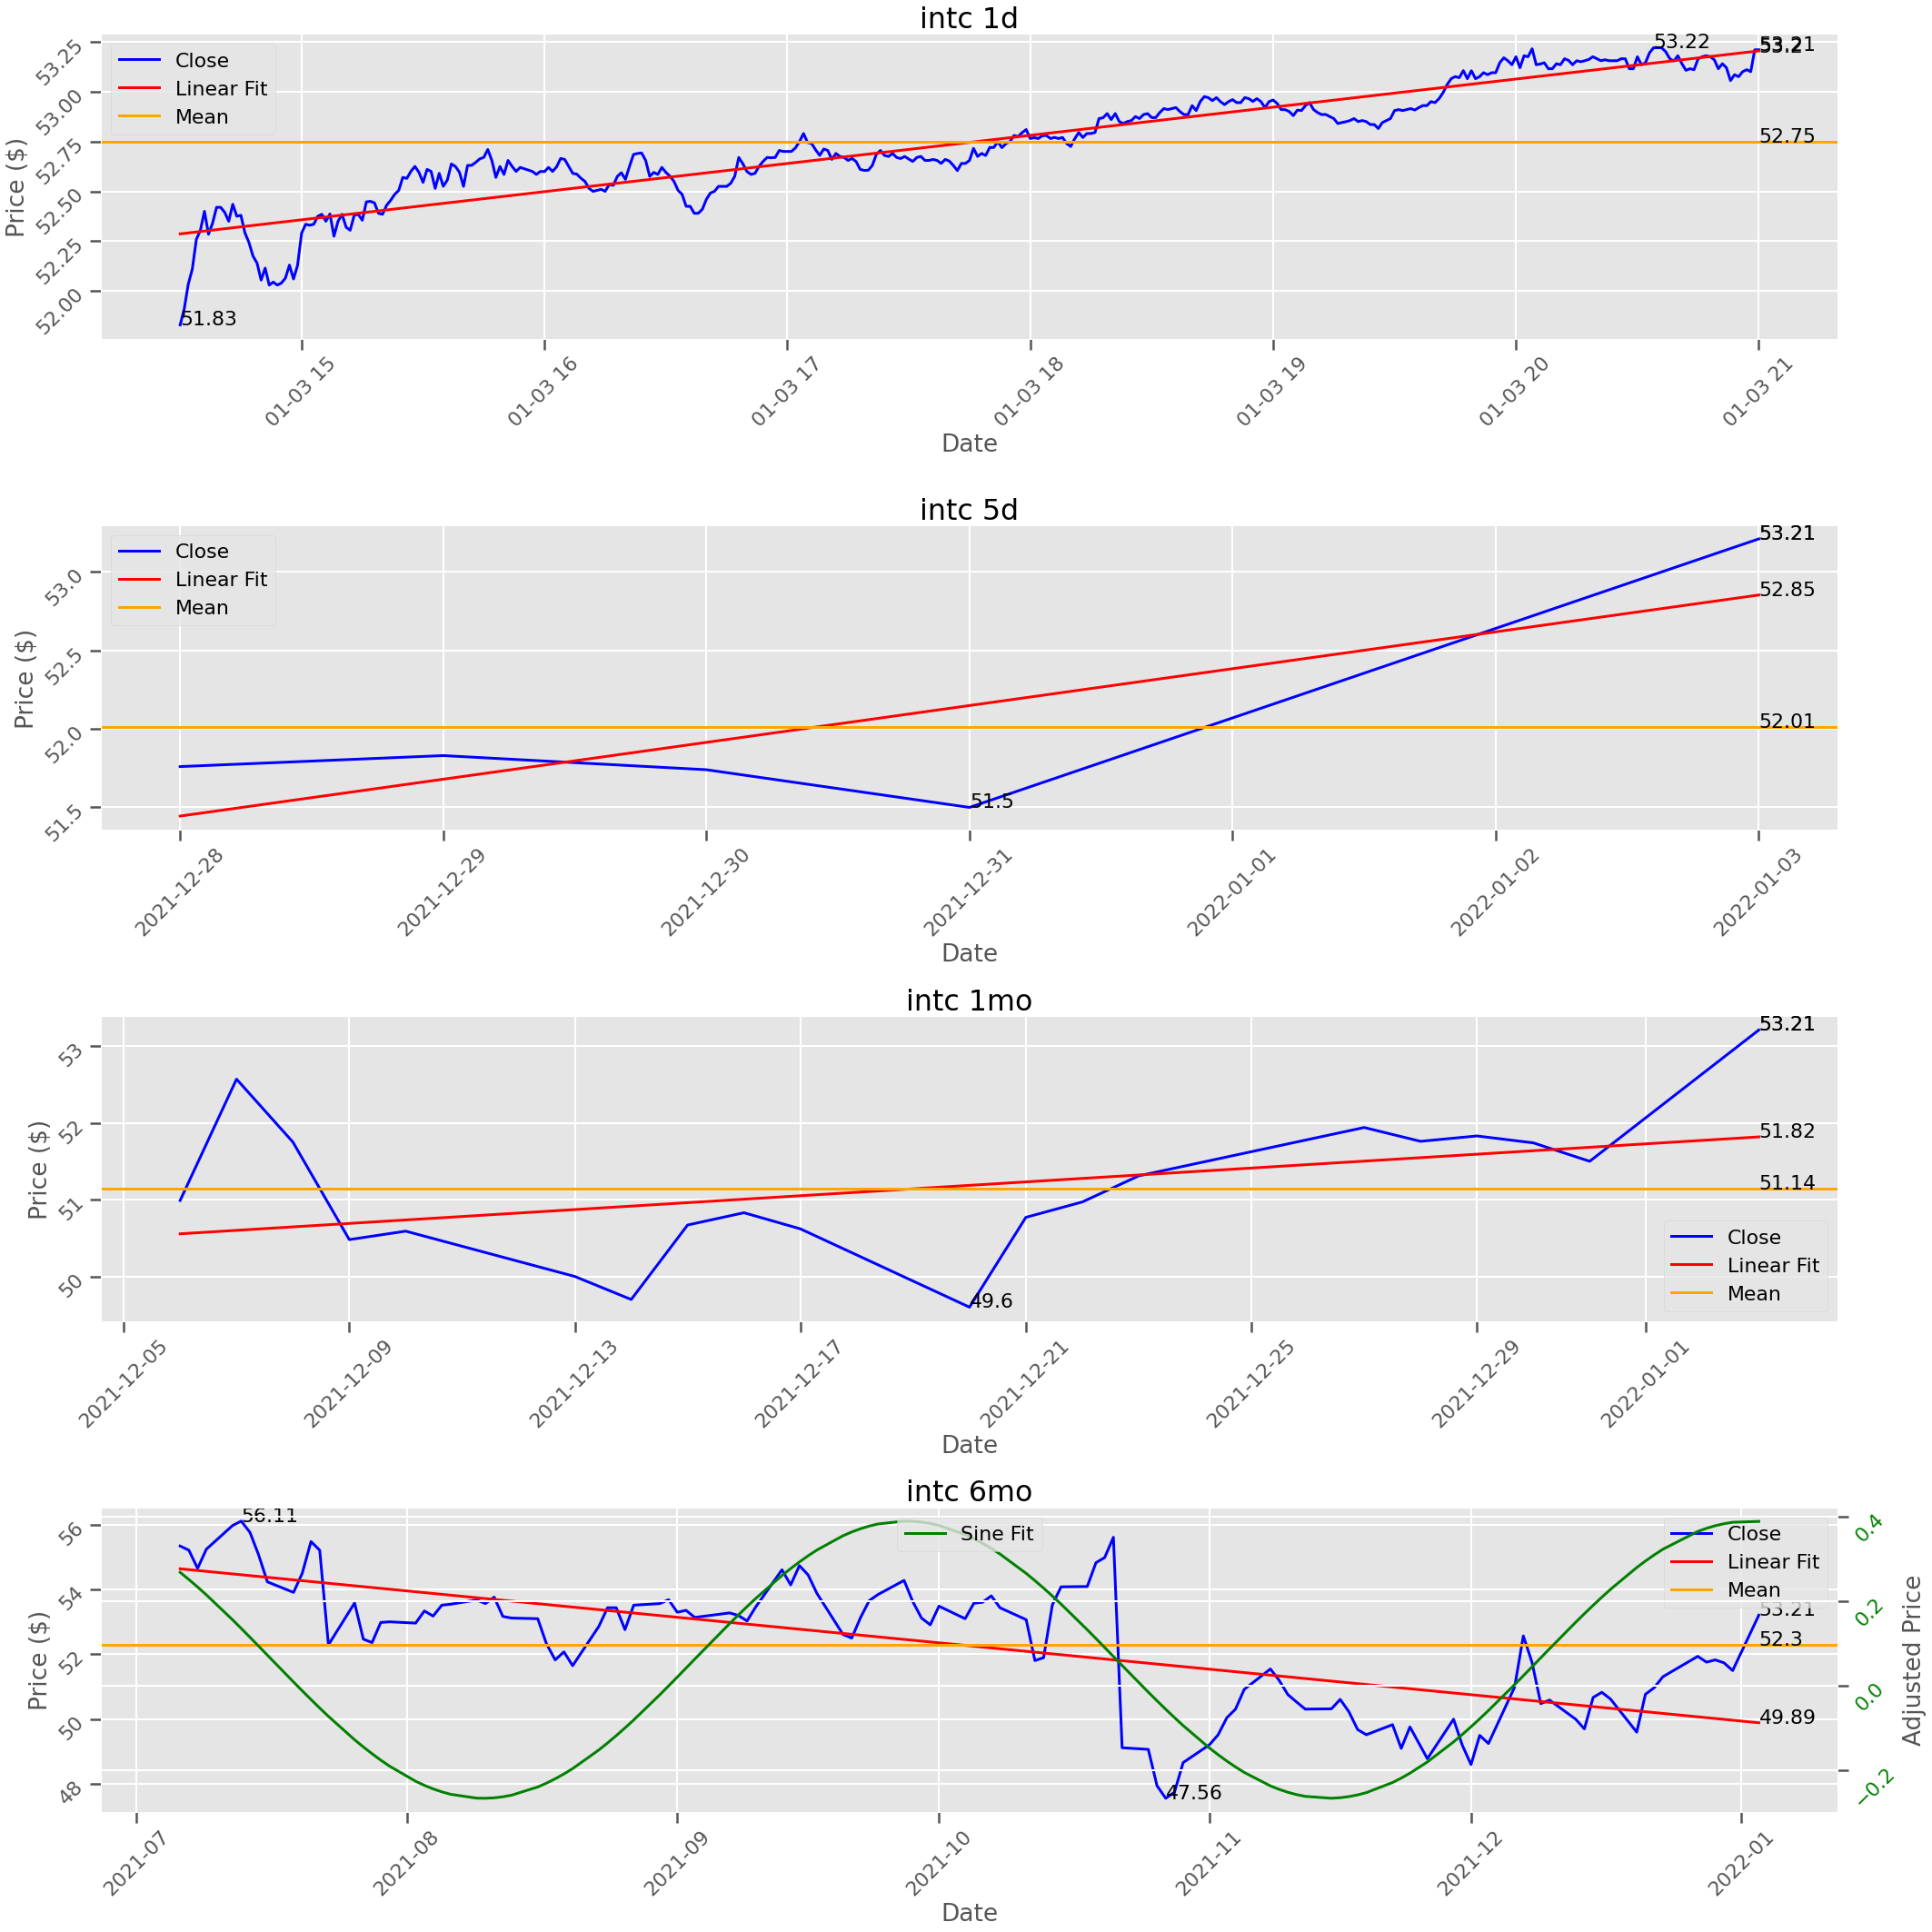

In [22]:
ticker = 'intc'
stock_dic = get_stock(ticker)
#put for loop below into get fits method?
#for i, key in enumerate(stock_dic.keys()):
#    if i > 0:
#        stock_dic[key] = get_fits(stock_dic[key], key)
get_fits(stock_dic)
val_df = get_values(stock_dic)
decision = analysis(stock_dic, val_df)
print(decision)
graph(stock_dic, val_df)

if ticker == 'amzn' and result in ('Buy', 'Sell'):
    amzn_analysis_tracking.loc[len(amzn_analysis_tracking.index)] = [val_df.loc['5d', 'last_idx'], decision, val_df.loc['5d', 'last_val']]
    amzn_analysis_tracking.to_csv(path_or_buf='C:/Users/seant/stock_analyzer/amzn_analysis_tracking.csv')